<a href="https://colab.research.google.com/github/alanjeffares/Simplex/blob/main/notebooks/rank_dist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/alanjeffares/Simplex.git

Cloning into 'Simplex'...
remote: Enumerating objects: 617, done.
remote: Counting objects: 100% (617/617), done.
remote: Compressing objects: 100% (413/413), done.
remote: Total 617 (delta 361), reused 396 (delta 153), pack-reused 0
Receiving objects: 100% (617/617), 1.17 MiB | 11.34 MiB/s, done.
Resolving deltas: 100% (361/361), done.


In [2]:
!pip install captum
!pip install pytorch_influence_functions

     |████████████████████████████████| 1.4 MB 7.7 MB/s 
  Created wheel for pytorch-influence-functions: filename=pytorch_influence_functions-0.1.1-py3-none-any.whl size=14966 sha256=b06232ff956ca85c966b952c8e5eaea484d584b09df76a944475ee59801d366d
  Stored in directory: /root/.cache/pip/wheels/1b/35/b0/f1ac8c66296a2fded385cfcd5d993fdd4c5ff7f33d24bf2fa7
Successfully built pytorch-influence-functions


In [3]:
%cd Simplex/
import explainers
from explainers.simplex import Simplex
import models
from models.image_recognition import MnistClassifier
from utils.schedulers import ExponentialScheduler
from experiments.mnist import load_mnist
%cd ../

/content/Simplex
/content


In [ ]:
# import sys, importlib
# %cd Simplex/
# importlib.reload(sys.modules['models.image_recognition'])
# from models.image_recognition import MnistClassifier
# %cd ../


In [32]:
# hyperparams
corpus_size = 100
cv_ls = list(range(10))

In [33]:
# run the code
%cd Simplex/
for cv in cv_ls:
  !python -m experiments.mnist -experiment "approximation_quality" -cv $cv -corpus_size $corpus_size
%cd ../

/content/Simplex
----------------------------------------------------------------------------------------------------
Welcome in the approximation quality experiment for MNIST. 
Settings: random_seed = 42 ; cv = 0.
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Now fitting the model. 
----------------------------------------------------------------------------------------------------

Test set: Avg. loss: 2.3168, Accuracy: 664/10000(7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.259823
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.266444
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.130428
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.129363
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.918430
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.712793
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.774907
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.565635
Train Epo

In [34]:
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_bar(dists: torch.tensor, selected_idx: torch.tensor):
  vals, _ = torch.sort(dists)
  plt.figure(figsize=(20,5))
  barlist = plt.bar(list(range(0,100)), vals.squeeze(0).cpu().numpy(), width=1)
  for idx in selected_idx:
    barlist[idx.item()].set_color('r')
  plt.show()

# corpus_data_ls = pickle.load( open( f"/content/Simplex/experiments/results/mnist/quality/corpus_data_cv{cv}.pkl", "rb" ) )
# [corpus_latent_reps, corpus_probas, corpus_true_classes] = corpus_data_ls

# test_data_ls = pickle.load( open( f"/content/Simplex/experiments/results/mnist/quality/test_data_cv{cv}.pkl", "rb" ) )
# [test_latent_reps, test_target] = test_data_ls

def load_run(cv: int):
  simplex = pickle.load( open( f"/content/Simplex/experiments/results/mnist/quality/simplex_cv{cv}_n5.pkl", "rb" ) )

  # load saved model
  classifier = MnistClassifier()
  classifier.load_state_dict(torch.load(f'/content/Simplex/experiments/results/mnist/quality/model_cv{cv}.pth'))
  classifier.to('cuda')
  classifier.eval()
  return simplex, classifier

simplex, classifier = load_run(0)

In [35]:
# for test example i which examples in the corpus have weight > 0.01
i = 0
test_i_lrg_corpus_weights = simplex.weights[i] > 0.01

In [36]:
# find the latent state of the test example
test_example = simplex.test_examples[i].unsqueeze(0)
test_example_latent_true = classifier.latent_representation(test_example)

# this is equivelent and returns the same vector
test_example_latent_true = simplex.test_latent_reps[i].unsqueeze(0)

# now grab the approximation of that vector in the corpus convex hull
test_latent_approx = simplex.latent_approx()
test_example_latent_approx = test_latent_approx[i].unsqueeze(0)

# distance between true latent and approx latent of test example
approx_dist = torch.sum((test_example_latent_approx - test_example_latent_true)**2)**0.5
print('Distance between latent approx and latent true:', approx_dist.item())

Distance between latent approx and latent true: 5.1901535987854


Latent test representation distance to each corpus representation is calcuated and ordered (low to high).
Then the rank of the corpus examples used in the reconstruction is extracted.

Approximate latent representation of the test example: tensor([ 1,  2, 11, 68], device='cuda:0')
With corresponding weight values:  tensor([0.2900, 0.4344, 0.0556, 0.2125], device='cuda:0')


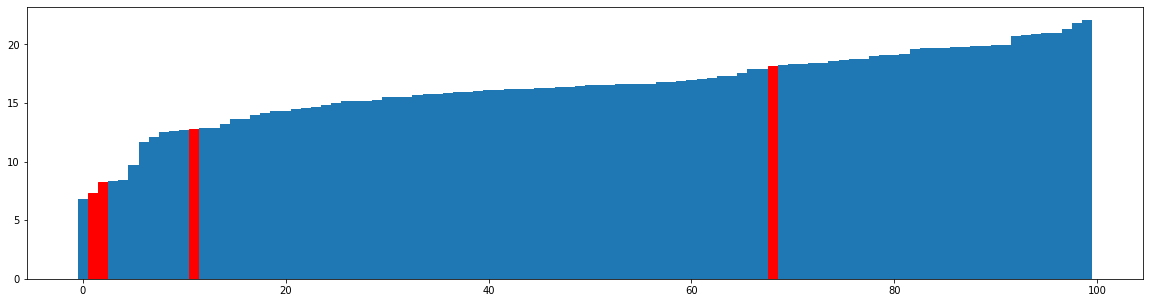


True latent representation of the test example: tensor([ 1,  2,  7, 54], device='cuda:0')
With corresponding weight values:  tensor([0.2900, 0.4344, 0.0556, 0.2125], device='cuda:0')


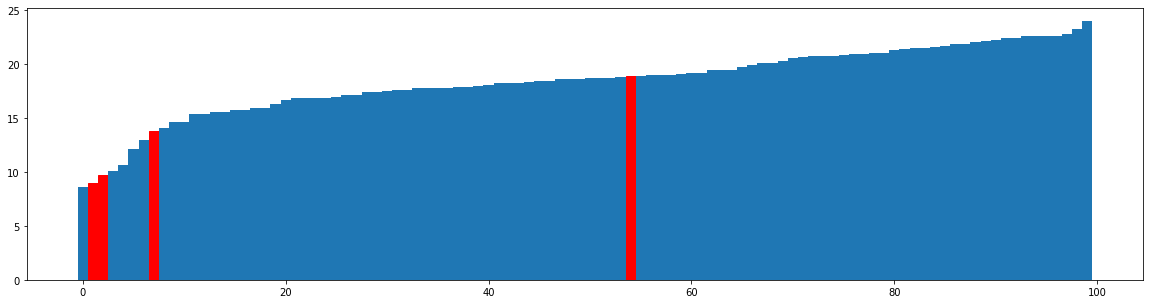

In [37]:
# calculate distance from test latent approximation to the highly weighted corpus examples
dists = torch.cdist(test_example_latent_approx, simplex.corpus_latent_reps)
_, ranks = torch.unique(dists, sorted=True, return_inverse=True)
sorted_ranks, _ = ranks[0,test_i_lrg_corpus_weights].sort()


print('Latent test representation distance to each corpus representation is calcuated and ordered (low to high).')
print('Then the rank of the corpus examples used in the reconstruction is extracted.\n')
print('Approximate latent representation of the test example:', sorted_ranks)
vals, idxs = torch.sort(dists)
weights = simplex.weights[i][idxs[0]][test_i_lrg_corpus_weights[idxs[0]]]
print('With corresponding weight values: ', weights)
plot_bar(dists, ranks[0,test_i_lrg_corpus_weights])


# calculate distance from test latent ground truth to the highly weighted corpus examples
dists = torch.cdist(test_example_latent_true, simplex.corpus_latent_reps)
_, ranks = torch.unique(dists, sorted=True, return_inverse=True)
sorted_ranks, _ = ranks[0,test_i_lrg_corpus_weights].sort()

print('\nTrue latent representation of the test example:', sorted_ranks)
vals, idxs = torch.sort(dists)
weights = simplex.weights[i][idxs[0]][test_i_lrg_corpus_weights[idxs[0]]]
print('With corresponding weight values: ', weights)

plot_bar(dists, ranks[0,test_i_lrg_corpus_weights])


In [38]:

def reconstruction_rank_dist(i, simplex):
  """
  Of the latent corpus examples used to approximate the test example with
  weight > 0.01, find and return their rank distance to the original latent test
  example of the 1000 total corpus examples and also return their associated 
  weights.
  """
  test_i_lrg_corpus_weights = simplex.weights[i] > 0.01

  # this is equivelent and returns the same vector
  test_example_latent_true = simplex.test_latent_reps[i].unsqueeze(0)

  # now grab the approximation of that vector in the corpus convex hull
  test_latent_approx = simplex.latent_approx()
  test_example_latent_approx = test_latent_approx[i].unsqueeze(0)

  # calculate distance from test latent approximation to the highly weighted corpus examples
  dists = torch.cdist(test_example_latent_approx, simplex.corpus_latent_reps)
  _, ranks = torch.unique(dists, sorted=True, return_inverse=True)
  sorted_ranks, _ = ranks[0,test_i_lrg_corpus_weights].sort()

  # calculate distance from test latent ground truth to the highly weighted corpus examples
  dists = torch.cdist(test_example_latent_true, simplex.corpus_latent_reps)
  _, ranks = torch.unique(dists, sorted=True, return_inverse=True)
  sorted_ranks, _ = ranks[0,test_i_lrg_corpus_weights].sort()

  vals, idxs = torch.sort(dists)
  weights = simplex.weights[i][idxs[0]][test_i_lrg_corpus_weights[idxs[0]]]
  return sorted_ranks, weights

def calculate_for_test(simplex):
  N_TEST = 100
  weighted_ranks = torch.empty(0, device='cuda')
  all_ranks = torch.empty(0, device='cuda')
  for i in range(N_TEST):
    sorted_ranks, weights = reconstruction_rank_dist(i, simplex)
    all_ranks = torch.cat([all_ranks, sorted_ranks])
    weighted_rank_i = sorted_ranks * weights
    weighted_ranks = torch.cat([weighted_ranks,weighted_rank_i])
  return weighted_ranks, all_ranks

In [41]:
n_test = 100
avg_weighted_ranks = []
avg_avg_ranks = []
all_ranks_full = []
for cv in cv_ls:
  simplex, classifier = load_run(cv)
  weighted_ranks, all_ranks = calculate_for_test(simplex)
  weighted_rank = weighted_ranks.sum()/n_test
  avg_rank = torch.mean(all_ranks)
  print('Weighted rank:', weighted_rank.item())
  print('Raw average rank: ', avg_rank.item())
  avg_weighted_ranks.append(weighted_rank.item())
  avg_avg_ranks.append(avg_rank.item())
  all_ranks_full.extend(all_ranks.cpu().tolist())
  


Weighted rank: 4.600566387176514
Raw average rank:  9.072639465332031
Weighted rank: 4.696116924285889
Raw average rank:  8.63990306854248
Weighted rank: 4.634210586547852
Raw average rank:  8.198564529418945
Weighted rank: 4.291878700256348
Raw average rank:  6.9666666984558105
Weighted rank: 4.871251106262207
Raw average rank:  8.108433723449707
Weighted rank: 4.389005184173584
Raw average rank:  7.814644813537598
Weighted rank: 4.754767894744873
Raw average rank:  8.380281448364258
Weighted rank: 4.415623188018799
Raw average rank:  8.540201187133789
Weighted rank: 4.449130535125732
Raw average rank:  8.580645561218262
Weighted rank: 3.538151741027832
Raw average rank:  5.783783912658691


In [42]:
print(np.mean(avg_weighted_ranks))
print(np.std(avg_weighted_ranks))


4.464070224761963
0.3531155690509162


In [43]:
print(np.mean(avg_avg_ranks))
print(np.std(avg_avg_ranks))

8.008576440811158
0.9163956636958143


In [45]:
print('Weighted rank:', weighted_ranks.sum()/n_test)
print('Raw average rank: ', torch.mean(all_ranks))

Weighted rank: tensor(3.5382, device='cuda:0')
Raw average rank:  tensor(5.7838, device='cuda:0')


In [ ]:
(all_ranks > 20).sum()

tensor(63, device='cuda:0')

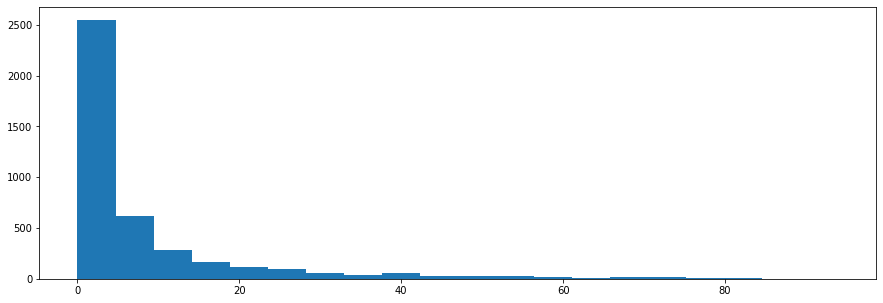

In [46]:
plt.figure(figsize=(15,5))
plt.hist(all_ranks_full, bins=20)
plt.show()

In [ ]:
# calculate distance from test latent approximation to the highly weighted corpus examples
dists = torch.cdist(test_example_latent, simplex.corpus_latent_reps)
sorted, indices = dists.sort()
indices[0,test_i_lrg_corpus_weights]

tensor([748, 653, 494, 670, 573], device='cuda:0')

In [ ]:
# calculate distance from test latent ground truth to the highly weighted corpus examples
dists = torch.cdist(test_example_latent_true, simplex.corpus_latent_reps)
sorted, indices = dists.sort()
indices[0,test_i_lrg_corpus_weights]

tensor([826, 785, 676], device='cuda:0')

In [ ]:
# distance from approx and true latent states of test example to obs j from the corpus
j = 6
print(torch.sum((test_example_latent_approx - simplex.corpus_latent_reps[j,:])**2)**0.5)
print(torch.sum((test_example_latent_true - simplex.corpus_latent_reps[j,:])**2)**0.5)

tensor(17.9488, device='cuda:0')
tensor(18.9352, device='cuda:0')


In [ ]:
simplex.corpus_latent_reps[0,:]

tensor([4.4077, 0.0000, 2.3789, 0.0000, 0.0000, 5.6503, 1.4715, 3.7833, 0.3766,
        0.3691, 0.0000, 0.0000, 0.6946, 0.0000, 0.0000, 0.0000, 3.0126, 0.0000,
        0.0000, 0.7745, 3.6202, 7.7748, 0.0000, 4.7042, 7.2362, 0.0000, 0.0000,
        0.0000, 2.1782, 0.0000, 3.4734, 0.3607, 0.0000, 0.0000, 5.8450, 0.0000,
        0.0000, 2.7952, 7.6346, 2.3497, 4.1248, 1.6305, 0.0000, 0.0000, 0.0000,
        2.3954, 8.2084, 7.5170, 0.0000, 2.2113], device='cuda:0')

tensor([463, 928, 118], device='cuda:0')

Fit explainer logic

In [72]:
# parameters 
random_seed = 42
cv = 0
path = f'/content/Simplex/experiments/results/mnist/quality/model_cv{cv}.pth'
device = 'cuda' if torch.cuda.is_available else 'cpu'
corpus_size = 100
test_size = 1
n_epoch = 1000
train_only = False
reg_factor_init = 0.1
reg_factor_final = 100
n_keep = 5

# main logic
torch.random.manual_seed(random_seed + cv)
explainers = []

# Load model:
classifier = MnistClassifier()
classifier.load_state_dict(torch.load(path))
classifier.to(device)
classifier.eval()

# Load data:
corpus_loader = load_mnist(corpus_size, train=True)
test_loader = load_mnist(test_size, train=train_only)
corpus_examples = enumerate(corpus_loader)
test_examples = enumerate(test_loader)
batch_id_test, (test_data, test_targets) = next(test_examples)
batch_id_corpus, (corpus_data, corpus_target) = next(corpus_examples)
corpus_data = corpus_data.to(device).detach()
test_data = test_data.to(device).detach()
corpus_latent_reps = classifier.latent_representation(corpus_data).detach()
corpus_probas = classifier.probabilities(corpus_data).detach()
corpus_true_classes = torch.zeros(corpus_probas.shape, device=device)
corpus_true_classes[torch.arange(corpus_size), corpus_target] = 1
test_latent_reps = classifier.latent_representation(test_data).detach()

# Fit SimplEx:
reg_factor_scheduler = ExponentialScheduler(reg_factor_init, reg_factor_final, n_epoch)
simplex = Simplex(corpus_examples=corpus_data,
                  corpus_latent_reps=corpus_latent_reps)
# simplex.fit(test_examples=test_data,
#             test_latent_reps=test_latent_reps,
#             n_epoch=n_epoch, reg_factor=reg_factor_init, n_keep=n_keep,
#             reg_factor_scheduler=reg_factor_scheduler)
simplex.fit_optimal(test_examples=test_data,
            test_latent_reps=test_latent_reps)

In [114]:
import sys, importlib
%cd Simplex/
importlib.reload(sys.modules['explainers.simplex'])
from explainers.simplex import Simplex
%cd ../

/content/Simplex
/content


In [90]:
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import Lars


def fit_optimal(self, test_examples, test_latent_reps: torch.tensor):
    H = self.corpus_latent_reps.cpu().numpy()
    test_latent_reps_np = test_latent_reps.cpu().numpy()
    n_test = test_latent_reps.shape[0]

    all_weights_full = np.empty((n_test, self.corpus_size))

    for i in range(n_test):
      h = test_latent_reps_np[i]

      size_corpus = H.shape[0]
      X = np.vstack([H, h])
      y = np.repeat([1,-1], [size_corpus, 1])
      
      svm = SVC(kernel="linear", C=1000, tol=1e-5)
      svm.fit(X, y)
      
      theta = svm.coef_
      theta_0 = svm.intercept_
      v = svm.support_vectors_[0]

      # find projection of test point on opposite side of optimal separating hyperplane
      d = theta.shape[1]
      I = np.identity(d)
      theta_sq = theta @ theta.T
      v_0 = - theta_0 * theta / theta_sq

      proj_plane = (I - (theta.T @ theta) / theta_sq) @ (v - v_0).T + v_0.T  # projection onto plane
      proj_hull = 2 * proj_plane - v[:,None]  # projection onto convex hull
      
      # check it found a separating hyperplane
      if not (y * (X @ theta.T + theta_0)[:,0] > 0).sum() == y.shape[0]:
          raise ValueError('Not a separating hyperplane - test point lies inside the convex hull')
      
      # solve for the weights (note: LARS is <O(d^2 n) complexity)
      num_weights = svm.support_vectors_[1:].T.shape[1]
      lars = Lars(fit_intercept=False, normalize=False, n_nonzero_coefs=num_weights)
      lars.fit(svm.support_vectors_[1:].T, proj_hull)
      w = lars.coef_ # values of (non-zero) weights
      w_idx = svm.support_[1:] # corresponding indices from the original corpus
      all_weights = np.ones(size_corpus) * 2
      np.add.at(all_weights, w_idx, w)
      all_weights_full[i] = all_weights
    
    device = 'cuda' if torch.cuda.is_available else 'cpu'
    self.weights = torch.tensor(all_weights_full, device=device, dtype=torch.float32)
    self.test_examples = test_examples
    self.test_latent_reps = test_latent_reps
    self.n_test = n_test
    self.hist = None



In [110]:
# parameters 
random_seed = 42
cv = 0
path = f'/content/Simplex/experiments/results/mnist/quality/model_cv{cv}.pth'
device = 'cuda' if torch.cuda.is_available else 'cpu'
corpus_size = 100
test_size = 1
n_epoch = 1000
train_only = False
reg_factor_init = 0.1
reg_factor_final = 100
n_keep = 5

# main logic
torch.random.manual_seed(random_seed + cv)
explainers = []

# Load model:
classifier = MnistClassifier()
classifier.load_state_dict(torch.load(path))
classifier.to(device)
classifier.eval()

# Load data:
corpus_loader = load_mnist(corpus_size, train=True)
test_loader = load_mnist(test_size, train=train_only)
corpus_examples = enumerate(corpus_loader)
test_examples = enumerate(test_loader)
batch_id_test, (test_data, test_targets) = next(test_examples)
batch_id_corpus, (corpus_data, corpus_target) = next(corpus_examples)
corpus_data = corpus_data.to(device).detach()
test_data = test_data.to(device).detach()
corpus_latent_reps = classifier.latent_representation(corpus_data).detach()
corpus_probas = classifier.probabilities(corpus_data).detach()
corpus_true_classes = torch.zeros(corpus_probas.shape, device=device)
corpus_true_classes[torch.arange(corpus_size), corpus_target] = 1
test_latent_reps = classifier.latent_representation(test_data).detach()

# Fit SimplEx:
reg_factor_scheduler = ExponentialScheduler(reg_factor_init, reg_factor_final, n_epoch)
simplex = Simplex(corpus_examples=corpus_data,
                  corpus_latent_reps=corpus_latent_reps)
# simplex.fit(test_examples=test_data,
#             test_latent_reps=test_latent_reps,
#             n_epoch=n_epoch, reg_factor=reg_factor_init, n_keep=n_keep,
#             reg_factor_scheduler=reg_factor_scheduler)
simplex.fit_optimal(test_examples=test_data,
            test_latent_reps=test_latent_reps)

[[6.78718544e-01]
 [2.50573651e+00]
 [3.82174427e+00]
 [1.27837939e-03]
 [2.87064805e+00]
 [8.55420645e-01]
 [4.79595909e-01]
 [2.67114282e+00]
 [6.50174465e-01]
 [1.04379486e-02]
 [2.99004933e+00]
 [7.53328801e-01]
 [6.66864520e-01]
 [2.58058651e-01]
 [3.34648522e-01]
 [2.91951717e+00]
 [8.24605389e-01]
 [4.07658287e+00]
 [6.46723325e-01]
 [2.96743114e+00]
 [9.65946883e-01]
 [5.42170800e+00]
 [0.00000000e+00]
 [9.25315925e-01]
 [1.31696171e+00]
 [0.00000000e+00]
 [9.60201159e-01]
 [7.74020955e-01]
 [1.56602870e+00]
 [1.08899871e+00]
 [3.08982697e+00]
 [5.11372983e-01]
 [6.99154772e-01]
 [8.70832738e-01]
 [9.23201432e-01]
 [3.36467520e+00]
 [0.00000000e+00]
 [4.28504224e+00]
 [2.07263995e+00]
 [3.43680362e+00]
 [1.27231578e+00]
 [2.34498806e+00]
 [2.43040648e+00]
 [2.92707341e+00]
 [1.17990704e+00]
 [1.71747543e+00]
 [5.82182962e+00]
 [5.19734751e+00]
 [9.29072731e-01]
 [3.66710148e+00]]


In [111]:
simplex.latent_approx()

tensor([[269.9886, 274.3505, 385.3306, 204.4398, 227.3402, 294.0723, 388.0108,
         182.7255, 308.9944, 192.4235, 187.9205, 376.7293, 298.1154, 331.5479,
         173.5808, 223.9094, 277.6101, 445.3861, 336.9451, 288.1857, 337.5789,
         369.1134, 144.0418, 350.5494, 306.4515, 158.8003, 493.9688, 371.7798,
         364.6609, 434.9784, 264.9983, 263.8355, 364.3654, 392.4078, 355.1985,
         371.5394, 277.0637, 425.1588, 391.6181, 517.1254, 356.8463, 376.6756,
         299.6625, 176.2598, 248.0298, 295.6180, 466.8196, 362.7202, 405.1676,
         405.1920]], device='cuda:0')

In [78]:
y = simplex.weights @ simplex.corpus_latent_reps
y.shape

torch.Size([1, 50])

In [113]:
simplex.weights.shape

torch.Size([1, 100])

In [85]:
((x - y)**2).sum()**0.5

tensor(5.9417, device='cuda:0')

In [86]:
y

tensor([[6.7872e-01, 2.5057e+00, 3.8217e+00, 1.2784e-03, 2.8706e+00, 8.5542e-01,
         4.7960e-01, 2.6711e+00, 6.5017e-01, 1.0438e-02, 2.9901e+00, 7.5333e-01,
         6.6686e-01, 2.5806e-01, 3.3465e-01, 2.9195e+00, 8.2461e-01, 4.0766e+00,
         6.4672e-01, 2.9674e+00, 9.6595e-01, 5.4217e+00, 0.0000e+00, 9.2532e-01,
         1.3170e+00, 0.0000e+00, 9.6020e-01, 7.7402e-01, 1.5660e+00, 1.0890e+00,
         3.0898e+00, 5.1137e-01, 6.9916e-01, 8.7083e-01, 9.2320e-01, 3.3647e+00,
         0.0000e+00, 4.2850e+00, 2.0726e+00, 3.4368e+00, 1.2723e+00, 2.3450e+00,
         2.4304e+00, 2.9271e+00, 1.1799e+00, 1.7175e+00, 5.8218e+00, 5.1973e+00,
         9.2907e-01, 3.6671e+00]], device='cuda:0')

In [88]:
6.7872e-01

0.67872

In [ ]:
    # def latent_representation(self, x: torch.Tensor,
    #                           test: bool = False) -> torch.Tensor:
    #     x = F.relu(F.max_pool2d(self.conv1(x), 2))
    #     if test:
    #       x = F.relu(F.max_pool2d(self.conv2(x), 2))
    #     else:
    #       x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    #     x = x.view(-1, 320)
    #     x = F.relu(self.fc1(x))
    #     if not test:
    #       x = F.dropout(x, training=self.training)
    #     return x

torch.Size([100, 50])

In [ ]:
%cd Simplex/
import explainers
import models
# from explainers.simplex import Simplex
# from models.image_recognition import MnistClassifier
# from experiments.mnist import load_mnist
%cd ../

/content/Simplex
/content


In [ ]:
%cd Simplex/
from explainers.simplex import Simplex
from models.image_recognition import MnistClassifier
from experiments.mnist import load_mnist
%cd ../

/content/Simplex
/content


In [ ]:
import sys, importlib
%cd Simplex/
importlib.reload(sys.modules['explainers.simplex'])
from explainers.simplex import Simplex
%cd ../

/content/Simplex
/content


In [ ]:

# Get a model
model = MnistClassifier() # Model should have the BlackBox interface

# Load corpus and test inputs
corpus_loader = load_mnist(subset_size=100, train=True, batch_size=100) # MNIST train loader
test_loader = load_mnist(subset_size=10, train=True, batch_size=10) # MNIST test loader
corpus_inputs, _ = next(iter(corpus_loader)) # A tensor of corpus inputs
test_inputs, _ = next(iter(test_loader)) # A set of inputs to explain

# Compute the corpus and test latent representations
corpus_latents = model.latent_representation(corpus_inputs).detach()
test_latents = model.latent_representation(test_inputs).detach()

# Initialize SimplEX, fit it on test examples
simplex = Simplex(corpus_examples=corpus_inputs, 
                  corpus_latent_reps=corpus_latents)
simplex.fit(test_examples=test_inputs, 
            test_latent_reps=test_latents,
            reg_factor=0)

# Get the weights of each corpus decomposition
weights = simplex.weights

Weight Fitting Epoch: 2000/10000 ; Error: 20.5 ; Regulator: 6.14 ; Reg Factor: 0
Weight Fitting Epoch: 4000/10000 ; Error: 17.1 ; Regulator: 2.47 ; Reg Factor: 0
Weight Fitting Epoch: 6000/10000 ; Error: 16.6 ; Regulator: 1.79 ; Reg Factor: 0
Weight Fitting Epoch: 8000/10000 ; Error: 16.5 ; Regulator: 1.65 ; Reg Factor: 0
Weight Fitting Epoch: 10000/10000 ; Error: 16.5 ; Regulator: 1.62 ; Reg Factor: 0


In [ ]:
import torch

# Compute the Integrated Jacobian for a particular example
i = 4
input_baseline = torch.zeros(corpus_inputs.shape) # Baseline tensor of the same shape as corpus_inputs
simplex.jacobian_projection(test_id=i, model=model,
                             input_baseline=input_baseline)

result = simplex.decompose(i)

START
tensor([ 3.4536e-01,  2.7351e-02,  2.3823e-01, -7.4672e-03,  4.3900e-01,
        -5.6099e-02, -3.9818e-02,  2.2314e-03,  3.3941e-02,  8.5732e-05,
         1.7575e-01,  3.7302e-05,  2.9429e-01,  3.2185e-02,  1.8232e-02,
         8.2373e-01,  8.5893e-02,  1.9391e-01,  2.8152e-02,  2.5287e-01,
         4.9622e-02,  2.2783e-02,  1.2279e-01,  1.8696e-01,  3.8638e-02,
         6.5950e-03,  4.7221e-02,  6.2021e-02,  3.5906e-02,  3.6956e-07,
         9.2338e-07, -5.0640e-02,  2.8502e-02, -2.4129e-02,  3.2652e-01,
         7.8590e-02, -2.5083e-02,  1.1306e-02,  7.9015e-02,  0.0000e+00,
         2.4351e-01,  2.7804e-01,  4.6262e-02,  1.2907e-01,  1.0201e-01,
         2.9487e-02,  1.2219e-05,  1.5570e-04,  1.7108e-01,  1.6670e-03],
       grad_fn=<SelectBackward0>)
tensor([ 3.4536e-01,  2.7351e-02,  2.3823e-01, -7.4672e-03,  4.3900e-01,
        -5.6099e-02, -3.9818e-02,  2.2314e-03,  3.3941e-02,  8.5732e-05,
         1.7575e-01,  3.7302e-05,  2.9429e-01,  3.2185e-02,  1.8232e-02,
         8

In [ ]:
c = 0
w_c, x_c, proj_jacobian_c = result[c]

In [ ]:
w_c

0.20396684